In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/signapoop/Desktop/fyp-graph-clustering'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pickle 
import numpy as np
import pandas as pd
import torch
import os
from timeit import default_timer as timer
import networkx as nx
import scipy.sparse as sp

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [5]:
from core.SimpleNet import SimpleNet
from core.OldGraphConvNet import OldGraphConvNet
from core.GraphConvNet import GraphConvNet
from core.EmbeddingDataSet import EmbeddingDataSet
from util.plot_graph_embedding import plot_graph_embedding
from util.evaluation_metrics import neighborhood_preservation, trustworthiness, evaluate_net_metrics
from util.graph_utils import get_shortest_path_matrix
from util.network_utils import get_net_projection

In [6]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [7]:
if torch.cuda.is_available():
    print('cuda available')
    device = 'cuda'
else:
    print('cuda not available')
    device = 'cpu'

cuda not available


In [8]:
dataset_name = 'cora_full'
parent_dir = os.path.abspath('..')
input_dir = os.path.join(parent_dir, 'data')
dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)

In [9]:
net_parameters = {}
net_parameters['n_components'] = 2
net_parameters['D'] = dataset.input_dim # input dimension
net_parameters['L'] = 2 # number of hidden layers

In [12]:
# Graph net
net_parameters['H'] = 128 # number of hidden units
net_1 = GraphConvNet(net_parameters)
if torch.cuda.is_available(): net_1.cuda()
root = 'results/cora_full_2/'
filename = root + 'graph_net_800.pkl'
checkpoint = torch.load(filename, map_location=device)
net_1.load_state_dict(checkpoint['state_dict'])

In [13]:
dataset.create_all_data(n_batches=1, shuffle=False)
y_pred_1 = get_net_projection(dataset.all_data, net_1)
y_pred_1 = y_pred_1[np.argsort(dataset.all_indices)]
plot_graph_embedding(y_pred_1, dataset.labels, dataset.adj_matrix)

Time to create all data (s) = 0.0263


In [14]:
net_2 = SimpleNet(net_parameters)
if torch.cuda.is_available(): net_2.cuda()
root = 'results/cora_full_3/'
filename = root + 'simple_net_3000.pkl'
checkpoint = torch.load(filename, map_location=device)
net_2.load_state_dict(checkpoint['state_dict'])

SimpleNet(
  (fc1): Linear(in_features=1433, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=2000, bias=True)
  (relu): ReLU()
  (fc4): Linear(in_features=2000, out_features=2, bias=True)
)

In [16]:
dataset.create_all_data(n_batches=1, shuffle=False)
y_pred_2 = get_net_projection(dataset.all_data, net_2)
y_pred_2 = y_pred_2[np.argsort(dataset.all_indices)]
plot_graph_embedding(y_pred_2, dataset.labels, dataset.adj_matrix)

Time to create all data (s) = 0.0256


In [10]:
path_matrix = get_shortest_path_matrix(dataset.adj_matrix)
path_matrix.shape

Computing all pairs shortest path lengths...
Time to compute shortest paths (s) = 24.3093


(2485, 2485)

In [39]:
embeddings_dict = {r'Full batch training': y_pred_3,
                   r'SGD': y_pred_4, 
                   r'SGD w NA': y_pred_2,
                   r'SGD w NA & NS': y_pred_1}

Text(0.5,1,'Graph preservation')

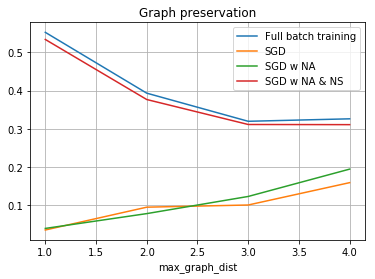

In [40]:
test_range = list(range(1, 5))
scores = np.zeros(len(test_range))

for label, embedding in embeddings_dict.items():
    for i, k in enumerate(test_range):
        scores[i] = neighborhood_preservation(path_matrix, embedding, max_graph_dist=k)
    plt.plot(test_range, scores, label=label)
        
plt.legend()
plt.xlabel('max_graph_dist')
plt.grid(True)
plt.title('Graph preservation')

Text(0.5,1,'Feature preservation')

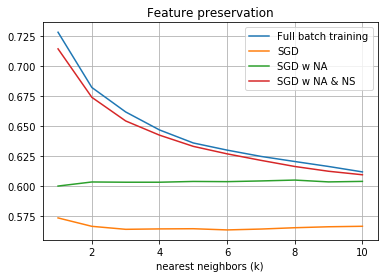

In [41]:
test_range = list(range(1, 11))
scores = np.zeros(len(test_range))

D = pairwise_distances(dataset.inputs, metric='cosine')

for label, embedding in embeddings_dict.items():
    for i, k in enumerate(test_range):
        scores[i] = trustworthiness(D, embedding, precomputed=True, n_neighbors=k)
    plt.plot(test_range, scores, label=label)
        
plt.legend()
plt.xlabel('nearest neighbors (k)')
plt.grid(True)
plt.title('Feature preservation')

In [10]:
net_1.eval()
G = dataset.all_data[0]
if torch.cuda.is_available():
    y_pred = net_1.forward(G).cpu().detach().numpy()
else:
    y_pred = net_1.forward(G).detach().numpy()

In [11]:
y_pred.shape

(622, 2)

In [12]:
plot_graph_embedding(y_pred, dataset.labels[:len(y_pred)], dataset.adj_matrix[:,:len(y_pred)][:len(y_pred),:])

## Out-of-sample predictions

In [13]:
# # Graph net
# net_1 = OldGraphConvNet(net_parameters)
# if torch.cuda.is_available(): net_1.cuda()
# root = 'results/cora_13/'
# filename = root + 'graph_net_1000.pkl'
# checkpoint = torch.load(filename, map_location=device)
# net_1.load_state_dict(checkpoint['state_dict'])

In [14]:
# dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)
# dataset.create_all_data(n_batches=3, shuffle=False)
# y_pred_1 = get_net_projection(dataset.all_data, net_1)
# y_pred_1 = y_pred_1[np.argsort(dataset.all_indices)]
# plot_graph_embedding(y_pred_1, dataset.labels, dataset.adj_matrix)

In [15]:
# dataset = EmbeddingDataSet(dataset_name, input_dir, train=False)
# dataset.create_all_data(n_batches=1, shuffle=False)
# y_pred_1 = get_net_projection(dataset.all_data, net_1)
# y_pred_1 = y_pred_1[np.argsort(dataset.all_indices)]
# plot_graph_embedding(y_pred_1, dataset.labels, dataset.adj_matrix)